# Random Forest Classifier

Before determining whether more data / new features are required to improve the predictive power of the models, I have built a random forest classifier. This utilises the concept of bootstrapping by repeatedly sampling distributions to build a more complex model than what is possible with standard logistic regression.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
%pip install vaderSentiment --quiet
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint as sp_randint
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/spotify/scripts

     |████████████████████████████████| 133kB 6.6MB/s 
Mounted at /content/gdrive
/content/gdrive/MyDrive/spotify/scripts


## Feature Engineering

As in the prior logistic regression model, I have created some simple features from each audio feature in the dataset and removed any columns that are strings. Each column has then been normalised to speed up algorithm convergence.  I have once again used a stratified K-fold, which forms a cross- validation over 5 folds to tune hyperparameters of my model.

In [2]:
df = pd.read_csv("../data/master_data.csv")

audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms']

df['year'] = df['release_date'].apply(lambda x: int(x[:4]))
df['popularity'] = df['popularity'].apply(lambda x: 1 if x>=50 else 0)

# Sentiment analysis of track title using VADER
analyser = SentimentIntensityAnalyzer()
df['sentiment'] = df['name'].apply(lambda x: analyser.polarity_scores(x)['compound'])

duration_mean = df['duration_ms'].mean()
df['duration_ms'].fillna(duration_mean, inplace=True)

print(pd.isnull(df).sum())
df.drop(labels=["track_number", "artist_name", "album", "name", "id", "uri",
                "release_date"], axis=1, inplace=True)
                
from sklearn.preprocessing import MinMaxScaler
x = df.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns = [*audio_features, "popularity", "year",
                                       "sentiment"])

neg, pos = np.bincount(df['popularity'])
total = pos + neg
# Assign class weights inversely proportional to count frequency of each class.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print('WEIGHT FOR CLASS 0: {:.2f}'.format(weight_for_0))
print('WEIGHT FOR CLASS 1: {:.2f}'.format(weight_for_1))

artist_name         0
album               0
track_number        0
id                  0
name                0
uri                 0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
duration_ms         0
release_date        0
popularity          0
year                0
sentiment           0
dtype: int64
WEIGHT FOR CLASS 0: 0.57
WEIGHT FOR CLASS 1: 3.91


In [3]:
x = df.drop(["popularity"], axis=1)
print('FEATURES:', x.columns)
y = df.loc[:,"popularity"].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(f"\nTraining features shape: {X_train.shape}.")
print(f"Training labels shape: {y_train.shape}.")
print(f"Test features shape: {X_test.shape}.")
print(f"Test labels shape: {y_test.shape}.")

FEATURES: Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
       'duration_ms', 'year', 'sentiment'],
      dtype='object')

Training features shape: (57033, 12).
Training labels shape: (57033,).
Test features shape: (14259, 12).
Test labels shape: (14259,).


In [4]:
def conf_matrix(y_test, pred_test):    
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 12}, fmt='g',
                cmap='Blues', cbar=False)
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()

## Random Forest Model

Let's begin by creating a baseline model to compare against our hyperparameter-tuned model. Even using the default settings for the RF model, we observe over a 10% increase in precision compared to the prior logistic regression model.

I have chosen precision as my metric of interest in this case, as we want to maximise the proportion of records that are true hits across all songs that are labelled as hits. This is because of the high cost of marketing required to promote a song, we want to make sure that a song truly has the potential to be successful before staking this upfront cost..

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
F1 SCORE: 0.2267175572519084
PRECISION: 0.34615384615384615



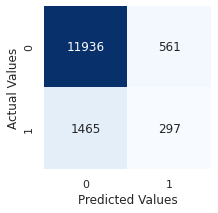

In [7]:
baseline_rf = RandomForestClassifier(class_weight="balanced_subsample")
baseline_rf.fit(X_train, y_train)
y_pred = baseline_rf.predict(X_test)
print(baseline_rf.get_params())
print(f"F1 SCORE: {f1_score(y_test, y_pred)}")
print(f"PRECISION: {precision_score(y_test, y_pred, zero_division=0)}\n")
conf_matrix(y_test, y_pred)

As in the logistic regression model prior, I have used a similar random search strategy to tune my model. Instead of focusing on class_weight in this case, I have looked at optimising the number of trees, their depth and the minimum number of samples per split.

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample')
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, X_train.shape[1]),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True],
              "n_estimators": sp_randint(250, 1000)}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=5, iid=False, verbose=1, 
                                   random_state=42).fit(X_train, y_train)
print(random_search.best_params_)

In [ ]:
print(random_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 709}


F1 SCORE: 0.2274629136553823
PRECISION: 0.34486735870818913
RECALL: 0.16969353007945517


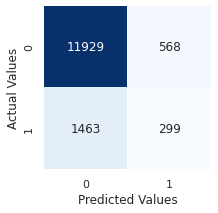

In [11]:
#best_rf = random_search.best_estimator_
best_rf = RandomForestClassifier(bootstrap=True, max_depth=None, max_features=5, 
           min_samples_split=2, n_estimators=709, random_state=42, n_jobs=-1, 
           class_weight='balanced_subsample')
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print(f"F1 SCORE: {f1_score(y_test, y_pred)}")
print(f"PRECISION: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"RECALL: {recall_score(y_test, y_pred, zero_division=0)}")
conf_matrix(y_test, y_pred)

## Final Conclusions

While it may appear that this model performs worse than the prior logistic regression, it has a significantly lower number of false positives, which I believe is far more important than the model's overall F1 Score, for the aforementioned costs of promoting a song that will not be a success regardless of the time or marketing placed behind it.

The model however still does not fit the dataset well [it is still only identifying ~20% of the true positives (hits)], the use of a random forest allows for significantly more complex behaviours to be learned by extending the number and depth of the tress in the ensemble. I have also built a series of neural networks in Keras that have not presented in this notebook, as they were not fitting to the dataset with sufficient precision to be worthy of presentation. It is clear that the current features in our model (which are specific to the song's structure and style) are not sufficiently powerful to predict whether a song will be a hit or not.

Given more time I would have adjusted my data collection pipeline to pull information about the artist for each song (such as their number of followers), while also using Billboard's API to identify whether a specific song is featured in their Top 100 or not, as this is a slightly fairer allocation of whether a song is a success or not. This set of notebooks has further highlighted to me the complexities of whether or not a track is a success. This is clearly due to the nuances of each genre and the specific target demographic that will determine a song's success.